<a href="https://colab.research.google.com/github/Anspire/Notebooks-keras/blob/master/Intel_image_classification_from_kaggle_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image classification

## Import all the necessary files!

In [0]:
import os
import time
import sys
import numpy as np
from google.colab import files
from google.colab import output

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import tensorflow as tf
import tensorflow.keras as k
from tensorflow.keras.preprocessing import image

%matplotlib inline

## Authenticating with Kaggle using kaggle.json

Navigate to https://www.kaggle.com. Then go to the [Account tab of your user profile](https://www.kaggle.com/me/account) and select Create API Token. This will trigger the download of kaggle.json, a file containing your API credentials.

Then run the cell below to upload kaggle.json to your Colab runtime.

In [3]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"anspire","key":"1e1f876bab62a4e09d74fd1453a4ecae"}'}

In [4]:
# Let's make sure the kaggle.json file is present.
!ls -lha kaggle.json

# Next, install the Kaggle API client.
!pip install -q kaggle

# The Kaggle API client expects this file to be in ~/.kaggle,
# so move it there.
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

-rw-r--r-- 1 root root 63 Sep 14 21:39 kaggle.json


### Download dataset from kaggle

In [5]:
# Copy the stackoverflow data set locally.
!kaggle datasets download -d puneet6060/intel-image-classification

 98% 337M/344M [00:05<00:00, 78.1MB/s]
100% 344M/344M [00:05<00:00, 64.6MB/s]


### Unzip dataset

In [6]:
print('Start unziping')

with output.use_tags('some_outputs'):
  get_ipython().system('unzip intel-image-classification.zip')
  get_ipython().system('unzip seg_pred.zip')
  get_ipython().system('unzip seg_test.zip')
  get_ipython().system('unzip seg_train.zip')
  get_ipython().system('rm intel-image-classification.zip')
  get_ipython().system('rm seg_pred.zip')
  get_ipython().system('rm seg_test.zip')
  get_ipython().system('rm seg_train.zip')
# Now clear the previous outputs.
output.clear(output_tags='some_outputs')
print('All done!')

Start unziping
All done!


## Draw Images


In [0]:
def draw_images(images, titles = None, ncols = 4):
  nimgs = len(images)
  nrows = nimgs // ncols
  if (nimgs % ncols) != 0:
    nrows = (nimgs // ncols) + 1
  f, ax = plt.subplots(nrows = nrows, ncols = ncols, figsize = (4 * ncols, 4 * nrows))
  for row in range(nrows):
    for col in range(ncols):
      index = (row * ncols) + col
      if index >= nimgs:
        break
      ax[row, col].imshow(images[index])
      if titles != None:
        ax[row, col].set_title(titles[index], fontsize=16)  
  plt.tight_layout()
  plt.show()

### Define training Directory 

In [0]:
train_dir = os.path.join('/content/seg_train')
test_dir = os.path.join('/content/seg_test')
pred_dir = os.path.join('/content/seg_pred')

Let's find out the total number of images in the category:

In [9]:
for cname in os.listdir(train_dir):
  print('total training {} images:'.format(cname), len(os.listdir(os.path.join(train_dir, cname))))

total training forest images: 2271
total training sea images: 2274
total training buildings images: 2191
total training street images: 2382
total training glacier images: 2404
total training mountain images: 2512


 Let's take a look at a few pictures of every category to get a better sense of what they look like:

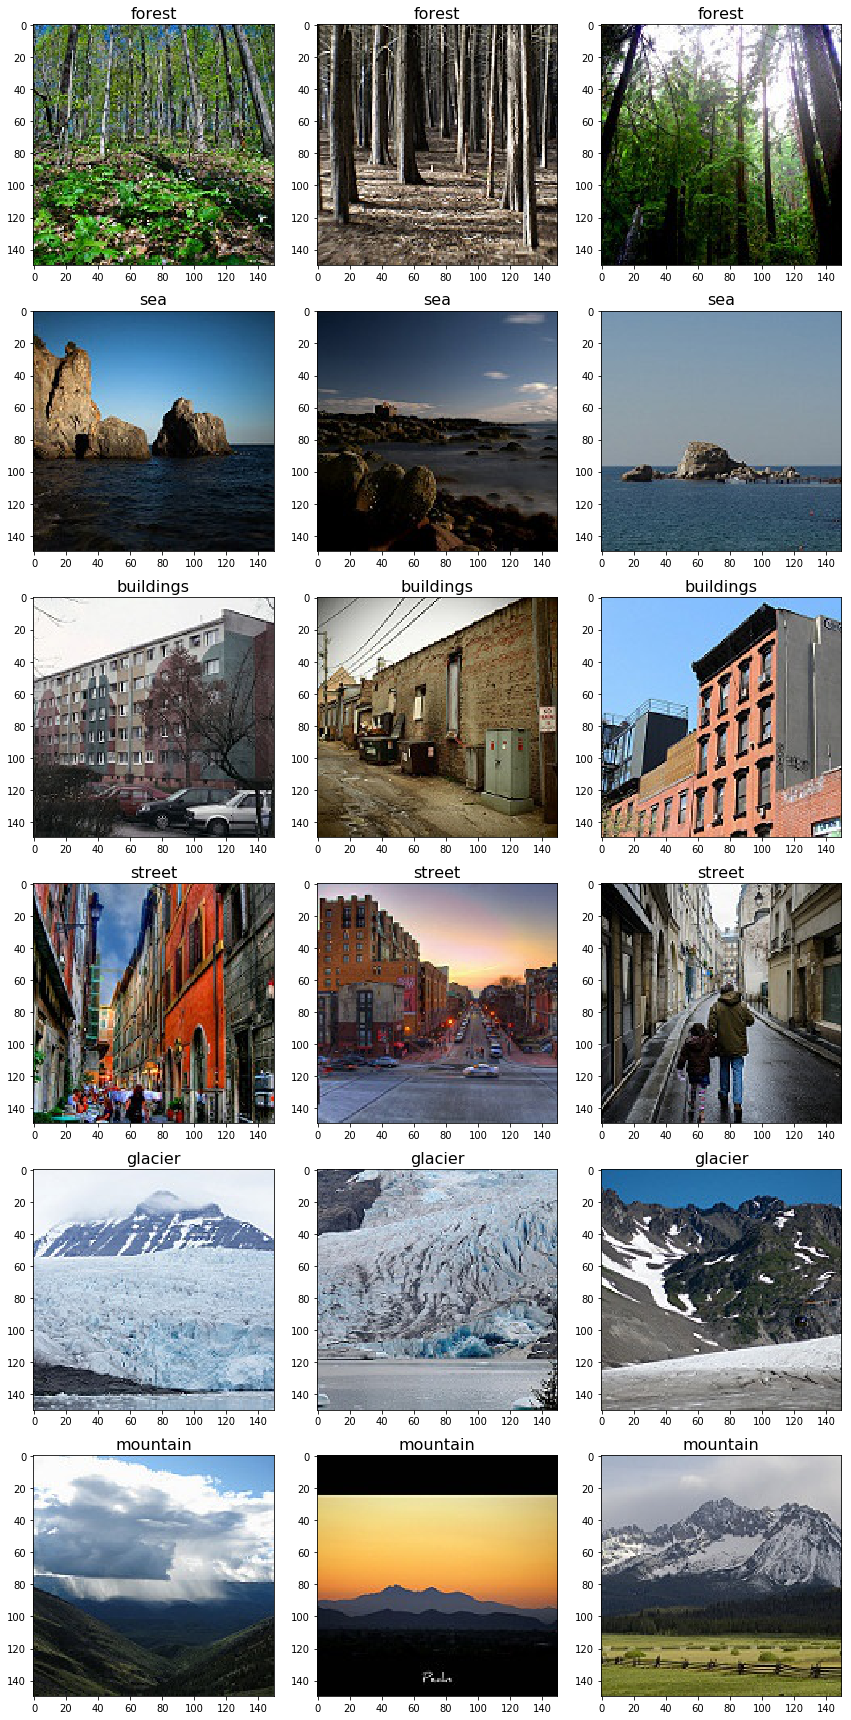

In [11]:
npic = 3 ## number of images from each category

pixs = list()
labels = list()
for cname in os.listdir(train_dir):
  files = os.listdir(os.path.join(train_dir, cname))
  for f_name in files[npic - npic: npic]:
    img_path = os.path.join(train_dir, os.path.join(cname, f_name))
    pixs.append(mpimg.imread(img_path))
    labels.append(img_path.split('/')[3])

draw_images(pixs, titles = labels, ncols = npic)

## Building a Small Model from Scratch

In [15]:
#tf.keras.backend.clear_session()

model = k.models.Sequential()
# Input shape is of the image 150x150 with 3 bytes color
# This is the first convolution
  
model.add(k.layers.Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(150, 150, 3)))
model.add(k.layers.Conv2D(32, (3,3), padding='same', activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(2, 2))
    
# The second convolution
model.add(k.layers.Conv2D(64, (3,3), padding='same', activation='relu'))
model.add(k.layers.Conv2D(64, (3,3), padding='same', activation='relu'))
model.add(k.layers.MaxPooling2D(5,5))                                               ,
# The third convolution
model.add(k.layers.Conv2D(128, (3,3), padding='same', activation='relu'))
model.add(k.layers.Conv2D(128, (3,3), padding='same', activation='relu'))
model.add(k.layers.MaxPooling2D(2,2))
# The fourth convolution
model.add(k.layers.Conv2D(256, (3,3), padding='same', activation='relu'))
model.add(k.layers.Conv2D(256, (3,3), padding='same', activation='relu'))
model.add(k.layers.MaxPooling2D(1,1))
# Flatten the results to feed into a DNN
model.add(k.layers.Flatten())
# 1024 neuron hidden layer
model.add(k.layers.Dense(1024, activation='relu'))
model.add(k.layers.Dense(512, activation='relu'))
model.add(k.layers.Dense(128, activation='relu'))
model.add(k.layers.Dropout(0.5))
model.add(k.layers.BatchNormalization())
# 6 output neuron.
model.add(k.layers.Dense(6, activation='softmax'))

model.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 150, 150, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 75, 75, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 75, 75, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 64)        0         
____

Configure the specifications for model training.Train model with the **categorical_crossentropy** loss, because it's a multi-class classification problem and final activation is a **softmax**.   Use the **adam** optimizer.

In [0]:
model.compile(loss='categorical_crossentropy',
              optimizer=k.optimizers.Adam(lr=0.0001),
              metrics=['acc'])

##Data Preprocessing

In Keras this can be done via the keras.preprocessing.image.ImageDataGenerator class using the rescale parameter. This ImageDataGenerator class allows you to instantiate generators of augmented image batches (and their labels) via .flow(data, labels) or .flow_from_directory(directory).

In [17]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1/255,
                                   horizontal_flip = True,
                                   rotation_range=20,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   validation_split=0.3) # set validation split

test_datagen = ImageDataGenerator(rescale=1/255)

# Flow training images in batches of 32 using train_.title('Training and validation accuracy')datagen generator
train_generator = train_datagen.flow_from_directory(
        train_dir,  # This is the source directory for training images
        target_size=(150, 150),  # All images will be resized to 150 x 150
        batch_size=32,
        shuffle = True,
        class_mode='categorical', # Since we use categorical_crossentropy loss, we need categorical labels
        subset='training') # set as training data

# Flow validation images in batches of 32 using train_datagen generator
validation_generator =  train_datagen.flow_from_directory( 
        train_dir,
        batch_size  = 32,
        shuffle = True,
        class_mode  = 'categorical',  # Since we use categorical_crossentropy loss, we need categorical labels
        target_size = (150, 150), # All images will be resized to 150 x 150
        subset='validation') # set as validation data

# Flow Test images in batches of 32 using train_datagen generator
test_generator =  test_datagen.flow_from_directory( 
        test_dir,
        batch_size  = 32,
        shuffle = True,
        class_mode  = 'categorical',  # Since we use categorical_crossentropy loss, we need categorical labels
        target_size = (150, 150))

Found 9826 images belonging to 6 classes.
Found 4208 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


### Get label map

In [18]:
label_map = (train_generator.class_indices)
print(label_map)
idx_to_label = {idx:lbl for lbl, idx in label_map.items()}
print(idx_to_label)

{'buildings': 0, 'forest': 1, 'glacier': 2, 'mountain': 3, 'sea': 4, 'street': 5}
{0: 'buildings', 1: 'forest', 2: 'glacier', 3: 'mountain', 4: 'sea', 5: 'street'}


## Training

Let's train for 30 epochs

In [19]:
epochs = 30

history = model.fit_generator(
      train_generator,
      steps_per_epoch = train_generator.samples // train_generator.batch_size,
      validation_data = validation_generator, 
      validation_steps = validation_generator.samples // validation_generator.batch_size, 
      epochs = epochs,
      verbose = 2)

Epoch 1/5
307/307 - 72s - loss: 1.1931 - acc: 0.5252 - val_loss: 1.3535 - val_acc: 0.5370
Epoch 2/5
307/307 - 67s - loss: 0.9506 - acc: 0.6424 - val_loss: 0.8232 - val_acc: 0.7092
Epoch 3/5
307/307 - 67s - loss: 0.8182 - acc: 0.6990 - val_loss: 0.7949 - val_acc: 0.6935
Epoch 4/5
307/307 - 67s - loss: 0.7344 - acc: 0.7429 - val_loss: 0.5957 - val_acc: 0.7836
Epoch 5/5
307/307 - 68s - loss: 0.6795 - acc: 0.7656 - val_loss: 0.8757 - val_acc: 0.6954


## Visualize Training/Validation Loss/Accuracy

In [0]:
def plot_history(history):
  """
  Plot training history
        """
  ## Trained model analysis and evaluation
  f, ax = plt.subplots(1,2, figsize=(12,3))
  ax[0].plot(history.history['loss'], label="Loss")
  ax[0].plot(history.history['val_loss'], label="Validation loss")
  ax[0].set_title('Loss')
  ax[0].set_xlabel('Epoch')
  ax[0].set_ylabel('Loss')
  ax[0].legend()

  # Accuracy
  ax[1].plot(history.history['acc'], label="Accuracy")
  ax[1].plot(history.history['val_acc'], label="Validation accuracy")
  ax[1].set_title('Accuracy')
  ax[1].set_xlabel('Epoch')
  ax[1].set_ylabel('Accuracy')
  ax[1].legend()
  plt.tight_layout()
  plt.show()

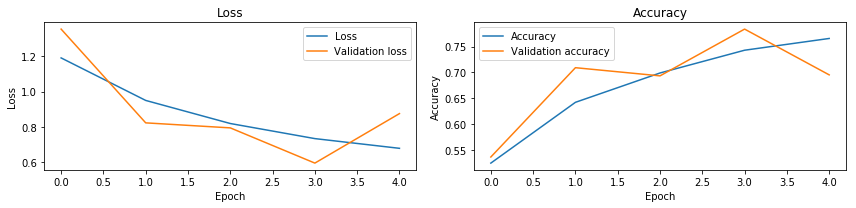

In [22]:
plot_history(history)

## Evaluate model

In [23]:
metrics_names = model.metrics_names
metrics = model.evaluate_generator(test_generator)

print(metrics_names[0] + ' = ', metrics[0])
print(metrics_names[1] + ' = ', metrics[1])

loss =  0.7407015964705893
acc =  0.73066664


## Running the Model

Let's now take a look at actually running a prediction using the model. This code will allow to read files from test directory, and run them through the model, giving an indication of category.

total test images: 7301


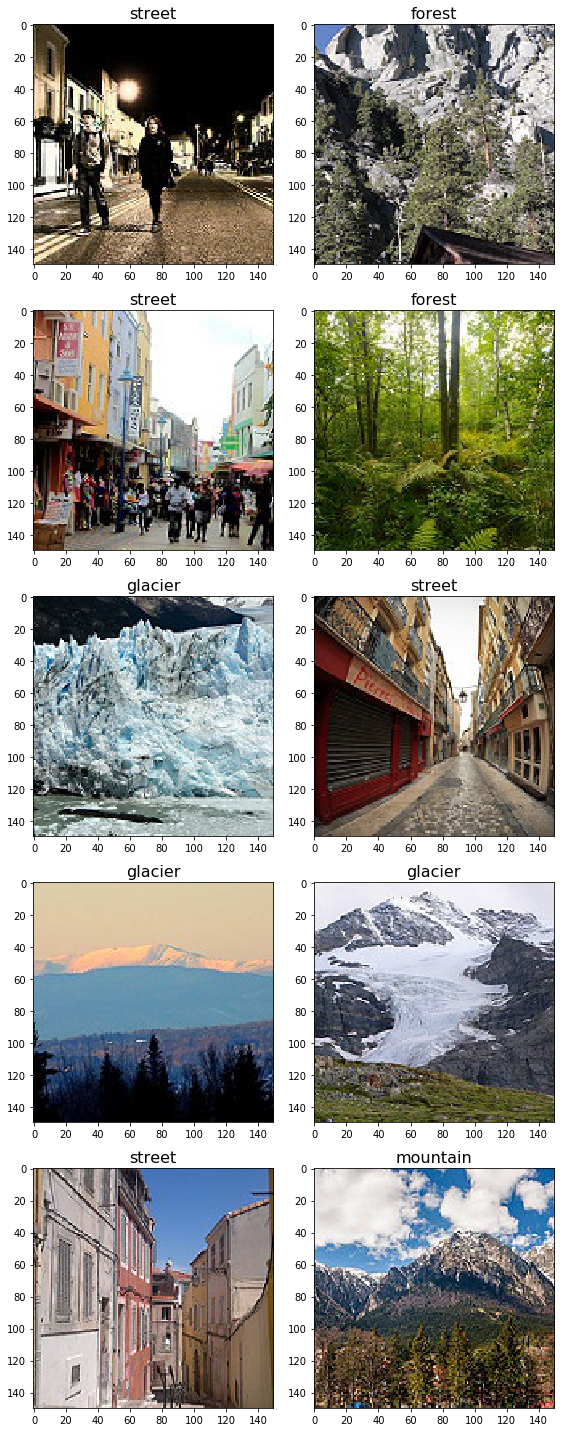

In [24]:
num_img = 10 ## number of images to test

test_img_names = os.listdir(pred_dir)
print('total test images:', len(test_img_names))

imgs = list()
plabel = list()
for fn in test_img_names[num_img - num_img: num_img]:
  # predicting images
  path = os.path.join(pred_dir, fn)
  img = image.load_img(path, target_size=(150, 150))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  images = np.vstack([x])
  classes = model.predict(images)

  imgs.append(img)
  plabel.append(idx_to_label[np.argmax(classes, axis= 1)[0]])

draw_images(imgs, titles = plabel, ncols = 2)